In [30]:
# -*- coding: utf-8 -*-

import os # 운영체제에 제공되는 기본적인 기능 제공, 디렉터리 접근, 생성 등
import zipfile # 압축 파일 관련 처리
import random # 샘플 추출
import tensorflow as tf

# from A import B : 모듈의 중복 예방, 호출 단순화
from tensorflow import lite # 텐서플로 라이트. 모바일,임베디드에 사용 가능하도록 경량화. 학습된 데이터(모델링)를 이용하는 용도
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from shutil import copyfile
import matplotlib.pyplot as plt # 데이터 시각화
import numpy as np

In [31]:
"""==========
   dataset 가져오기
   =========="""

liste = ["daisy","dandelion","rose","sunflower","tulip","marigold", "buttercup", "camellia", "cape flower", "blackberry lily" ]
         

# training, testing 폴더 만들기
try :
    os.mkdir("db/training")
    os.mkdir("db/testing")

except OSError :
    pass

# training, testing 하단에 각각의 꽃 폴더 만들기
for variety in liste :
    try :
        os.mkdir("db/training/" + variety)
        os.mkdir("db/testing/" + variety)
    except OSError :
        pass


In [32]:
def split_data(SOURCE, TRAINING,TESTING,SPLIT_SIZE) :
    files = []
    for filename in os.listdir(SOURCE) :
        file = SOURCE + filename
        if os.path.getsize(file) > 0 :
            files.append(filename)
        else :
            print(filename + "is zero length, so ignoring")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files,len(files)) # 컬렉션에서 일부를 샘플링해서 뽑아냄. sample(컬랙션, 샘플수). 리스트 셔플 용도로 쓰임
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]
    
    for filename in training_set :
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file,destination)
    
    for filename in testing_set :
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file,destination)

In [33]:
"""==========
   train, test dataset 만들기
   =========="""

split_size = .8

for name in liste :
    SOURCE_DIR = "db/" + name + "/"
    TRAINING_DIR = "db/training/" + name + "/"
    TESTING_DIR = "db/testing/" + name + "/"
    
    split_data(SOURCE_DIR,TRAINING_DIR,TESTING_DIR,split_size)
    # 각각의 꽃마다 split_data 함수 실행
    # source : 
    # training : 
    # testing : 


# training
TRAINING_DIR = "db/training/"
training_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

training_generator = training_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size = (300,300),
        class_mode = "categorical")

# testing
TESTING_DIR = "db/testing/"
testing_datagen = ImageDataGenerator(rescale = 1./255)

testing_generator = testing_datagen.flow_from_directory(
        TESTING_DIR,
        target_size = (300,300),
        class_mode = "categorical")

Found 3930 images belonging to 10 classes.
Found 987 images belonging to 10 classes.


In [34]:
"""==========
   모델 구성하기
   =========="""

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation = "relu", input_shape = (300,300,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation = "relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation = "relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation = "relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation = "relu"),
        tf.keras.layers.Dense(10, activation = "softmax")
        ])

In [35]:
"""==========
   모델 학습과정 설정하기
   =========="""

model.compile(loss = "categorical_crossentropy", optimizer = RMSprop(lr=0.001), metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 147, 147, 64)      36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 33, 33, 128)      

In [36]:
"""==========
   모델 학습하기
   =========="""

history = model.fit_generator(training_generator,
                              epochs = 3,
                              validation_data = testing_generator,
                              verbose = 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 123 steps, validate for 31 steps
Epoch 1/3
123/123 [==============================] - 627s 5s/step - loss: 1.9639 - accuracy: 0.3102 - val_loss: 1.5902 - val_accuracy: 0.4144
Epoch 2/3
123/123 [==============================] - 1041s 8s/step - loss: 1.4259 - accuracy: 0.4738 - val_loss: 1.2709 - val_accuracy: 0.5360
Epoch 3/3
123/123 [==============================] - 563s 5s/step - loss: 1.2986 - accuracy: 0.5313 - val_loss: 1.1410 - val_accuracy: 0.6039


In [37]:
# 모델 저장
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)

# 모델 weight 저장
keras_file="flower.h5"
model.save(keras_file)

KeyError: 'acc'

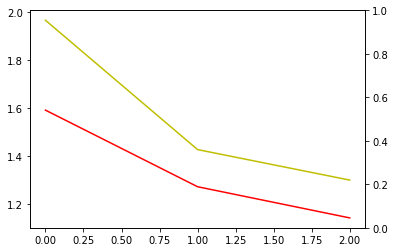

In [38]:
# 모델 학습 그래프 확인
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()